In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict

torch.cuda.empty_cache()


In [2]:
###Image Prep

In [3]:
###Functions 

def splitter(dataset,split=(70,15,15),seed=None):

    assert sum(split)==100

    dataset_length = len(dataset)
    
    if seed != None:
        np.random.seed(seed)
        
    train_data = []
    valid_data = []
    test_data = []
        
    for i in range(0,len(dataset)):
      
        chance = np.random.randint(0,100)

        if chance < split[0]:
            train_data.append(dataset[i,])
            
        elif chance >= split[0] and chance < (split[0]+split[1]):
            valid_data.append(dataset[i,])
        
        elif chance >= (split[0]+split[1]) and chance < sum(split): 
            test_data.append(dataset[i,])
            
        else: 
            print(chance)
  
    return np.array(train_data), np.array(valid_data), np.array(test_data)
        
    
def showRandomSamples(dataset,path='DATA/Images/destination/',seed=42):
    
    pick = np.random.randint(0,len(dataset),size=1)
    
    fig = plt.figure()
    
    #ax = fig.subplots(1,4)
    
    #for i,i_img in enumerate(pick):
        
     #   ax = fig.add_subplot(1,1,(i+1))
    img = dataset[pick]['image']
    plt.imshow(img)
    
    return none

def dynDevice():
    if torch.cuda.device_count() == 0:
        device = 'cpu'
    elif torch.cuda.device_count() > 0:
        device = 'cuda'
        nDevice = torch.cuda.device_count()  #setup for later implementation of multi gpu parallel processing
    return device

print(dynDevice())

  
def inv_normalize(x):
    
    
    
    return x

cuda


In [4]:
annotations = pd.read_csv('Garth_ML_index.csv')
#annotations_good.drop(['Unusable', 'Moderately good'], axis=1, inplace=True)
quality = np.array(np.arange(0,len(annotations))).astype('float64')

for i in range(0,len(quality)):
    if not np.isnan(annotations['Unusable'][i]):
        quality[i]= 0.0
    elif not np.isnan(annotations['Moderately good'][i]):
        quality[i]= 1.0
    elif not np.isnan(annotations['Good-number of layers'][i]):
        quality[i] = 2.0
    
annotations_class = annotations.copy()
annotations_class['quality'] = quality
print(annotations_class.dtypes)
print(len(annotations))  
annotations_class.head()




File Name                 object
Unusable                 float64
Moderately good          float64
Good-number of layers    float64
quality                  float64
dtype: object
16896


,File Name,Unusable,Moderately good,Good-number of layers,quality
0,"Garth_A01_G006_0001[0,0].jpg",1.0,NaN,NaN,0.0
1,"Garth_A01_G006_0001[0,1].jpg",1.0,NaN,NaN,0.0
2,"Garth_A01_G006_0001[0,2].jpg",1.0,NaN,NaN,0.0
3,"Garth_A01_G006_0001[0,3].jpg",1.0,NaN,NaN,0.0
4,"Garth_A01_G006_0001[0,4].jpg",1.0,NaN,NaN,0.0


In [5]:
###Setup Model

In [11]:
class OneModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = torch.nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv3 = torch.nn.Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = torch.nn.Linear(in_features=24*24*9, out_features=2048, bias=True)
        self.fc2 = torch.nn.Linear(in_features=2048, out_features=512, bias=True)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        

        

    def forward(self,x):
        
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.elu(self.conv3(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.max_pool2d(x,kernel_size=2,stride=2).view(-1,24*24*9)
        x = F.elu(self.fc1(x))
        x = F.relu(self.fc2(F.dropout(x,p=0.2)))
        x = self.fc3(F.dropout(x,p=0.2))
        return x
    
    


model = OneModel()

print(model)

total=0
for param in model.parameters():
    total+=param.numel()
    print(param.numel())

print('________________')
print(total)


OneModel(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)
75
3
450
6
1350
9
10616832
2048
1048576
512
1024
2
________________
11670887


In [12]:
(((224-4)/2-4)/2-4)/2

24.5

In [13]:
24*24*15

8640

In [14]:
#import torchvision.models as models
#vgg = models.vgg11(pretrained=True)

In [15]:
###Custom Data Loader

class customDs(Dataset):
    
    def __init__(self,dataset,path = 'DATA/Images/destination/', transforms=None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.path = path
        
        return None
    
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self,idx):

        image = Image.open(self.path+self.dataset[idx][0])
        quality =self.dataset[idx][4]
        n_layers = self.dataset[idx][3] if not np.isnan(self.dataset[idx][3]) else self.dataset[idx][2] if not np.isnan(self.dataset[idx][2]) else 0
        
        categs = torch.tensor([quality,n_layers],dtype=float)
        
        
        ##Encode for ML##
        
        if self.transforms!=None:
            image = self.transforms(image)
            
       # print(image.shape, torch.max(image))
        

        sample = {'image':image,'categs':categs}

        return sample

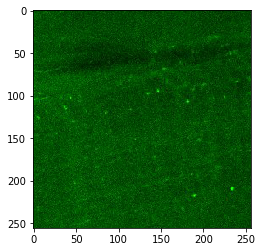

In [16]:
path = 'DATA/Images/destinations/'
img = cv2.imread('DATA/Images/destination/Garth_A01_G006_0007[0,1].jpg')
plt.imshow(img)

In [17]:
#train-valid-test split = 70%, 15%, 15%
np.random.seed(42)
ann_train, ann_valid, ann_test = splitter(annotations_class.values,(70,15,15))

print(len(ann_train))
print(len(ann_valid))
print(len(ann_test))

11821
2520
2555


In [18]:
tf_trainDs = customDs(ann_train,transforms=tf.Compose([
                              #                 tf.Grayscale(num_output_channels=1),
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomVerticalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.05, p=0.05, interpolation=3),
                                               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.Grayscale(),
                                               tf.ToTensor(),
                   #                            tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

                          

tf_validDs = customDs(ann_valid,transforms=tf.Compose([
                               #                tf.Grayscale(num_output_channels=1),
                               #                tf.RandomHorizontalFlip(p=0.5),
                               #                tf.RandomVerticalFlip(p=0.5),
                               #                tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                               #                tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.Grayscale(),
                                               tf.ToTensor(),
                  #                             tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

tf_testDs = customDs(ann_test,transforms=tf.Compose([
                                #               tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.Grayscale(),
                                               tf.ToTensor(),
                     #                          tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))


batchSize = 2
train_loader = DataLoader(tf_trainDs, batch_size = batchSize, pin_memory=True, drop_last=True,shuffle=True, num_workers=0)
valid_loader = DataLoader(tf_validDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=True, num_workers=0)
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=True, num_workers=0)

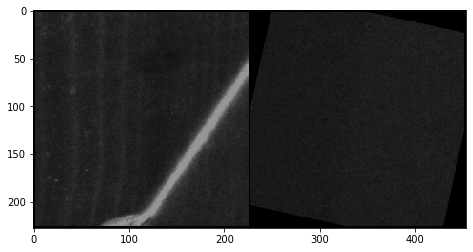

In [19]:
for sample in train_loader:
    img, label = sample['image'], sample['categs']
    break
    
im = make_grid(img,nrow=12)
plt.figure(figsize=(12,4))

plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [20]:
#initiate model, loss function, optimization function

torch.cuda.empty_cache()

#model = vgg
#for param in model.parameters():
#    param.requires_grad = False

#classifier = torch.nn.Sequential(OrderedDict([
#                          ('fullyconnectedlayer1', torch.nn.Linear(25088, 2048)),    #unclear how to determine size of input tensor
#                          ('relu1', torch.nn.ReLU()),
#                          ('drop1', torch.nn.Dropout(0.22)),
    #                      ('fullyconnectedlayer2', torch.nn.Linear(2550, 1024)),
    #                      ('relu2', torch.nn.ReLU()),
    #                      ('drop2', torch.nn.Dropout(0.22)),
    #                      ('fullyconnectedlayer3', torch.nn.Linear(1024, 512)),
    #                      ('relu3', torch.nn.ReLU()),
    #                      ('drop3', torch.nn.Dropout(0.15)),
#                          ('fullyconnectedlayer4', torch.nn.Linear(2048, 512)),
#                          ('relu4', torch.nn.ReLU()),
#                          ('drop4', torch.nn.Dropout(0.15)),
#                          ('fullyconnectedlayer5', torch.nn.Linear(512, 2))
#                          ]))
    
#model.classifier = classifier


criterion = torch.nn.SmoothL1Loss()
#criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

model.to(device = dynDevice(), dtype=torch.double)


OneModel(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)

In [23]:
epochs = 1
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []



for i in range(0,epochs): 
    
    epoch_start = time.time()
    i=0
    losses=0
    accuracies=[0,0,0]

    model.train()
    for sample in train_loader:
        i+=1
        img, label = sample['image'], sample['categs']
        img, label = img.to(device = dynDevice(), dtype=torch.double), label.to(device = dynDevice(), dtype=torch.double)
        result = model(img)
        loss = criterion(result,label)
        losses+=loss.item()
        
        #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
        for j in range(result.shape[0]):
            if round(result[j,0:1].item())==round(label[j,0:1].item()):
                accuracies[0]=accuracies[0]+1
                if round(result[j,0:1].item()) == 2:
                    accuracies[1] = accuracies[1] + 1
                    if round(result[j,1:2].item()) == round(label[j,1:2].item()):
                        accuracies[2] = accuracies[2] + 1

        

   #     if i%500 ==0:
   #         print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies[0]/i}')
   #         break
        
        
        #Update Model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        


    try: 
        training_accuracies.append([accuracies[0]/(i*batchSize),accuracies[2]/accuracies[1]])  
    except ZeroDivisionError:
        training_accuracies.append([accuracies[0]/(i*batchSize),0])      
        
    training_losses.append(losses/i)       
    training_end =time.time()

    #Validate
    i=0
    losses=0
    accuracies=[0,0,0]
    model.eval()
    with torch.no_grad():
        for sample in valid_loader:
            i+=1
            img, label = sample['image'], sample['categs']
            img, label = img.to(device = dynDevice(), dtype=torch.double), label.to(device = dynDevice(), dtype=torch.double)
            result = model(img)
            loss = criterion(result,label)
            losses+=loss.item()

            #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
            for j in range(result.shape[0]):
                if round(result[j,0:1].item())==round(label[j,0:1].item()):
                    accuracies[0]=accuracies[0]+1
                    if round(result[j,0:1].item()) == 2:
                        accuracies[1] = accuracies[1] + 1
                        if round(result[j,1:2].item()) == round(label[j,1:2].item()):
                            accuracies[2] = accuracies[2] + 1
         #   if i%200 ==0:
         #       print(f'Validation BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies[0]/i}')
         #       break
 
        try: 
            validation_accuracies.append([accuracies[0]/(i*batchSize),accuracies[2]/accuracies[1]])  
        except ZeroDivisionError:
            validation_accuracies.append([accuracies[0]/(i*batchSize),0])  
        
        validation_losses.append(losses/i)       
        validation_end = time.time()
    
    print(f'The epoch took {(validation_end-epoch_start):.0f}s. \n    training took {(training_end-epoch_start):.0f}s \n    validation took {(validation_end-training_end):.0f}s')

    print(f'\nLosses were \n    training loss: {training_losses[-1]:.3f} \n    validation loss: {validation_losses[-1]:.3f}')
    
    print(f'\nOn average, the model\n    got the quality right in {100*validation_accuracies[-1][0]:.1f}% \n    counted the correct number of labels in  {100*validation_accuracies[-1][1]:.1f}%')
    

    

The epoch took 418s. 
    training took 403s 
    validation took 15s

Losses were 
    training loss: 1.406 
    validation loss: 0.425

On average, the model
    got the quality right in 56.5% 
    counted the correct number of labels in  0.0%


In [17]:
accuracies

[0, 0, 0]